## Vector Error Correction Model ( 벡터오차수정모형)

   - 단위근 검정
   - 차수 설정
   - 공적분 검정 
   - VECM 모형 설정 
   - 인과관계 검정 
   - 충격반응분석
   - 예측

In [1]:
#pip install numpy==1.19.5

In [2]:
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
import pandas as pd

In [4]:
pd.__version__

'1.3.5'

In [5]:
import os

import pandas as pd
import numpy as np
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')


import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools


import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [6]:
pd.__version__

'1.3.5'

In [7]:
np.__version__

'1.19.5'

In [8]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [9]:
import scipy
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [10]:
scipy.__version__

'1.9.2'

In [11]:
#https://stackoverflow.com/questions/71106940/cannot-import-name-centered-from-scipy-signal-signaltools

In [12]:
from scipy.signal.signaltools import _centered

In [13]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR,VECM
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [14]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data[['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']]
data = data[0:-60] 
print(data.shape)
data.dtypes

(210, 10)


TEU             int64
BDI             int64
ln(HRCI)      float64
ln(SCFI)      float64
수출물가지수        float64
환율            float64
전산업생산지수       float64
경상수지          float64
ln(다우존스지수)    float64
화물수송총괄          int64
dtype: object

In [15]:
data.describe()

,TEU,BDI,ln(HRCI),ln(SCFI),수출물가지수,환율,전산업생산지수,경상수지,ln(다우존스지수),화물수송총괄
count,2.100000e+02,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,2.100000e+02
mean,1.510997e+06,2454.442857,2.808339,2.993291,113.719667,1125.667381,83.352381,2875.107143,4.082184,9.293274e+07
std,4.696987e+05,2170.810159,0.270640,0.092474,10.279686,108.533411,14.853238,3552.724851,0.107389,2.908790e+07
min,5.707200e+05,317.000000,1.913430,2.617142,92.730000,915.860000,51.900000,-3845.000000,3.848985,1.669310e+05
25%,1.171254e+06,962.750000,2.654422,2.942633,103.972500,1059.695000,70.625000,290.550000,4.010211,8.035873e+07
50%,1.475862e+06,1623.500000,2.755731,3.010328,114.305000,1128.055000,84.900000,2128.000000,4.049233,9.303172e+07
75%,1.935030e+06,3110.500000,3.048217,3.051596,120.617500,1182.107500,96.150000,5692.025000,4.146849,1.142120e+08
max,2.365726e+06,11440.000000,3.318637,3.196644,140.100000,1461.980000,116.500000,12409.700000,4.329390,1.401112e+08


### 단위근 검정
 - H0 : 비정상 시계열 --> 사용
 - H1 : 정상 시계열  --> 제거 

In [16]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'   ADF 검정 : "{name}"', "\n   ", '-'*47)
    print(f' H0 : 단위근 존재 --> 비정상 시계열.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. H0 기각")
        print(f" => 정상 시계열 .")
    else:
        print(f" => P-Value = {p_value}. H0 채택")
        print(f" => 비정상 시계열")
        
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print()

   ADF 검정 : "TEU" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -0.812
 => P-Value = 0.8156. H0 채택
 => 비정상 시계열

   ADF 검정 : "BDI" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -2.0425
 => P-Value = 0.2683. H0 채택
 => 비정상 시계열

   ADF 검정 : "ln(HRCI)" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -2.6371
 => P-Value = 0.0856. H0 채택
 => 비정상 시계열

   ADF 검정 : "ln(SCFI)" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -1.9013
 => P-Value = 0.3315. H0 채택
 => 비정상 시계열

   ADF 검정 : "수출물가지수" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -2.2161
 => P-Value = 0.2005. H0

<AxesSubplot:>

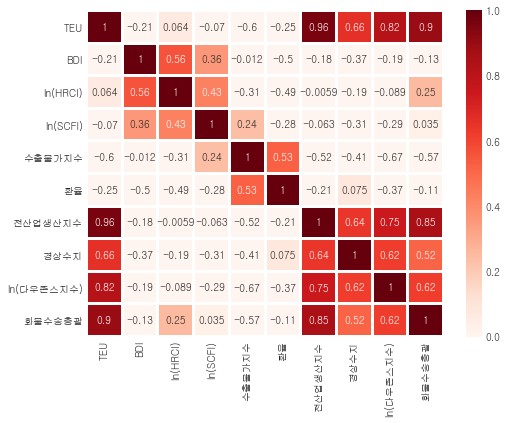

In [17]:
# 상관계수 확인 
plt.rcParams["figure.figsize"] = (8,6)
sns.heatmap(data.corr(), annot=True, cmap='Reds', linewidths=2, vmin=0)

### VECM 차수 설정

In [18]:
import warnings 
warnings.filterwarnings(action='ignore')

In [19]:
df = data

In [20]:
model = vecm.select_order(df, maxlags=6)
model.summary()

,AIC,BIC,FPE,HQIC
0,69.30,71.10*,1.253e+30,70.03
1,67.68,71.11,2.501e+29,69.07*
2,67.35,72.41,1.815e+29,69.39
3,67.29,73.98,1.771e+29,70.00
4,67.31,75.63,1.901e+29,70.67
5,67.15,77.10,1.756e+29,71.17
6,67.02*,78.60,1.731e+29*,71.70


### 공적분 검정 ( Johansen Cointegration Test)
   - H0 : 공적분 존재 X --> VAR
   - H1 : 공적분 존재 O --> VECM(장기적 균형관계 성립) [ Trace 통계량, MaxEigenValue]

In [21]:
rank_test = select_coint_rank(df, 1, 1, method="trace",signif=0.05)
rank_test.rank # Trace 

4

In [22]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,10,423.7,259.0
1,10,270.5,215.1
2,10,191.4,175.2
3,10,140.6,139.3
4,10,103.1,107.3


In [23]:
rank_test = select_coint_rank(df, 1, 1, method="maxeig",signif=0.05)
rank_test.rank # Eigen

2

In [24]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,1,153.2,67.90
1,2,79.09,61.81
2,3,50.84,55.73


### VECM 모형 설정

In [23]:
# add seasonality and the deterministic trend which is 

#    "nc" - no deterministic terms
#    "co" - constant outside the cointegration relation
#    "ci" - constant within the cointegration relation
#    "lo" - linear trend outside the cointegration relation
#    "li" - linear trend within the cointegration relation

In [25]:
model = VECM(df,deterministic='colo', k_ar_diff= 6, coint_rank=3,seasons=4) # coli
vecm_res = model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,-1.819e+06,6.17e+05,-2.947,0.003,-3.03e+06,-6.09e+05
season1,-1998.5694,1.57e+04,-0.127,0.899,-3.28e+04,2.88e+04
season2,-3.978e+04,1.6e+04,-2.487,0.013,-7.11e+04,-8435.161
season3,4184.6539,1.56e+04,0.269,0.788,-2.63e+04,3.47e+04
lin_trend,247.6924,349.577,0.709,0.479,-437.466,932.851
L1.TEU,-0.1903,0.120,-1.588,0.112,-0.425,0.045
L1.BDI,35.3315,6.618,5.338,0.000,22.360,48.303
L1.ln(HRCI),8.754e+04,2.39e+05,0.366,0.714,-3.81e+05,5.56e+05
L1.ln(SCFI),4.022e+05,1.33e+05,3.017,0.003,1.41e+05,6.64e+05
L1.수출물가지수,-2059.6822,2596.893,-0.793,0.428,-7149.499,3030.134


#### 오차의 자기상관 확인 --> DW검정

In [26]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(vecm_res.resid)
for col, val in zip(data.columns, out):
    print((col), ':', round(val, 2))

TEU : 1.93
BDI : 2.0
ln(HRCI) : 2.02
ln(SCFI) : 1.95
수출물가지수 : 1.95
환율 : 1.97
전산업생산지수 : 1.86
경상수지 : 2.07
ln(다우존스지수) : 1.95
화물수송총괄 : 2.04


### VECM 그레인저 인과관계
    * 시차 조정 시도

In [26]:
granger_results = vecm_res.test_granger_causality(causing='BDI',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.467,1.802,0.005,"(11, 720)"


In [27]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="BDI", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.339,1.802,0.008,"(11, 720)"


In [28]:
granger_results = vecm_res.test_granger_causality(causing='ln(HRCI)',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.469,1.802,0.005,"(11, 720)"


In [29]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="ln(HRCI)", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.820,1.802,0.047,"(11, 720)"


In [30]:
granger_results = vecm_res.test_granger_causality(causing='ln(SCFI)',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.245,1.802,0.011,"(11, 720)"


In [31]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="ln(SCFI)", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
3.019,1.802,0.001,"(11, 720)"


In [32]:
granger_results = vecm_res.test_granger_causality(causing='수출물가지수',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.558,1.802,0.106,"(11, 720)"


In [33]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="수출물가지수", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.631,1.802,0.086,"(11, 720)"


In [34]:
granger_results = vecm_res.test_granger_causality(causing='전산업생산지수',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
5.490,1.802,0.000,"(11, 720)"


In [35]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="전산업생산지수", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
4.357,1.802,0.000,"(11, 720)"


In [36]:
granger_results = vecm_res.test_granger_causality(causing='경상수지',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.214,1.802,0.012,"(11, 720)"


In [37]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="경상수지", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
3.075,1.802,0.000,"(11, 720)"


In [38]:
granger_results = vecm_res.test_granger_causality(causing='환율',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.960,1.802,0.030,"(11, 720)"


In [39]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="환율", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
4.509,1.802,0.000,"(11, 720)"


In [40]:
granger_results = vecm_res.test_granger_causality(causing='ln(다우존스지수)',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.517,1.802,0.120,"(11, 720)"


In [41]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="ln(다우존스지수)", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.651,1.802,0.080,"(11, 720)"


In [42]:
granger_results = vecm_res.test_granger_causality(causing='화물수송총괄',caused="TEU", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.131,1.802,0.016,"(11, 720)"


In [43]:
granger_results = vecm_res.test_granger_causality(causing='TEU',caused="화물수송총괄", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
4.395,1.802,0.000,"(11, 720)"


### VECM 충격반응분석

In [44]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

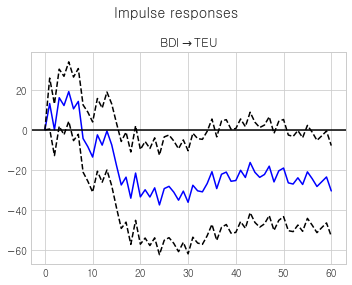

In [45]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='BDI',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

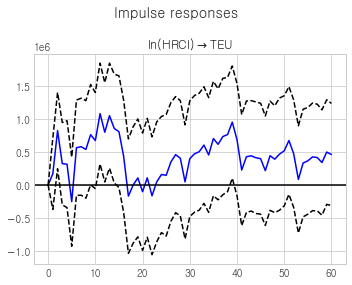

In [46]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='ln(HRCI)',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

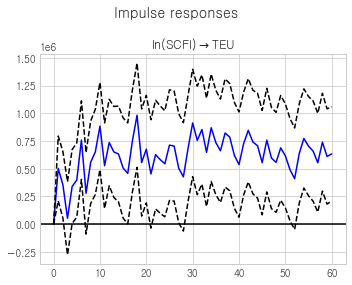

In [47]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='ln(SCFI)',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

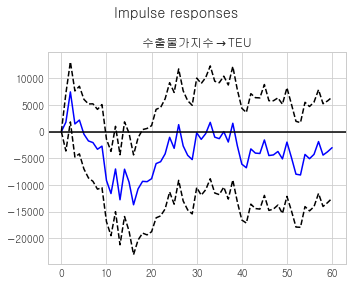

In [48]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='수출물가지수',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

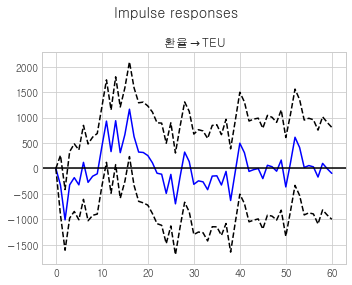

In [49]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='환율',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

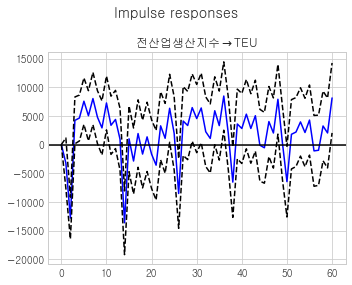

In [50]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='전산업생산지수',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

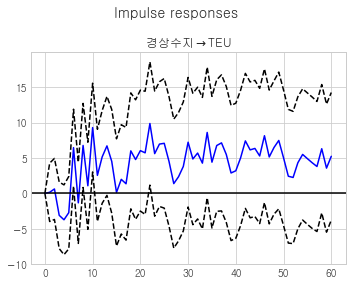

In [51]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='경상수지',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

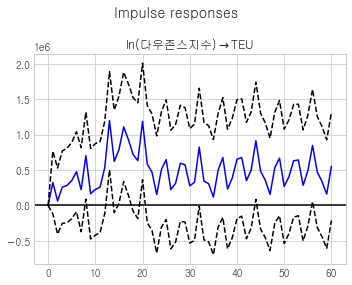

In [52]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='ln(다우존스지수)',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

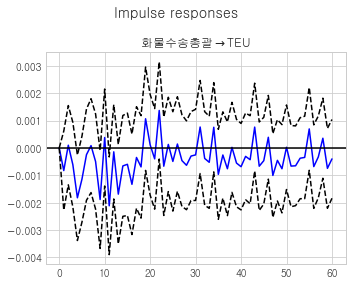

In [53]:
forecast_num = 60
vecm_res.irf(forecast_num).plot(impulse='화물수송총괄',response='TEU',figsize=(5,4))
plt.tight_layout() 
plt.show()

###  예측값

In [27]:
pd.options.display.float_format = "{:.0f}".format
forecast, lower, upper = vecm_res.predict(60, 0.05)
print("\npoint forecasts:")
print(pd.DataFrame(forecast.round(2)))


point forecasts:
         0     1  2  3   4    5   6     7  8         9
0  2375358  1062  3  3 103 1122 105  4331  4 145149332
1  2250098  1046  3  3 103 1127 103  7934  4 131640754
2  2287794  1194  3  3 106 1171 110 10434  4 136493444
3  2331289  1274  3  3 108 1193 105  6845  4 134224815
4  2215609  1125  3  3 106 1177 106  6843  4 124276118
5  2328013   739  3  3 105 1190 115  6245  4 134499058
6  2225274  -102  2  3 106 1193 102  4036  4 131559545
7  2187352  -348  2  3 106 1204 102  6718  4 125589322
8  2358606  -535  2  3 107 1226 111  7756  4 135036148
9  2326642  -484  2  3 107 1225 108  4989  4 131368593
10 2260308  -316  2  3 107 1235 105  7722  4 127901537
11 2212707  -280  2  3 107 1241 109  8209  4 123353070
12 2303299  -279  2  3 106 1230 106  7118  4 128317525
13 2215948  -353  2  3 105 1219 106  6806  4 118215304
14 2298799  -555  2  3 105 1226 111  8396  4 126364821
15 2272612  -621  2  3 105 1228 106  7647  4 123635086
16 2285749  -533  2  3 104 1226 109  8794  4 12

In [28]:
df2 = pd.read_csv('TEU_전국.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.set_index('Date')
df2 = df2[-60:].reset_index()

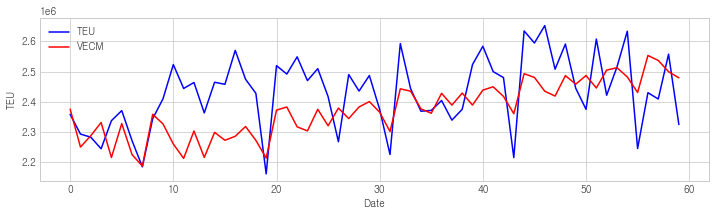

In [29]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(df2.TEU, label='TEU',color='blue')
plt.plot(pd.DataFrame(forecast.round(2))[0], label='VECM',color='red')
plt.legend()

In [30]:
mse = mean_squared_error(df2['TEU'], pd.DataFrame(forecast.round(2))[0])
print('MSE: '+str(mse))
rmse = math.sqrt(mse)
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((df2['TEU']-pd.DataFrame(forecast.round(2))[0])/df2['TEU'])*100) )

MSE: 15781272111.544764
RMSE: 125623.53327121779
MAPE: 4.275928426618875


RMSE: 125623.53327121779
MAPE: 4.275928426618875


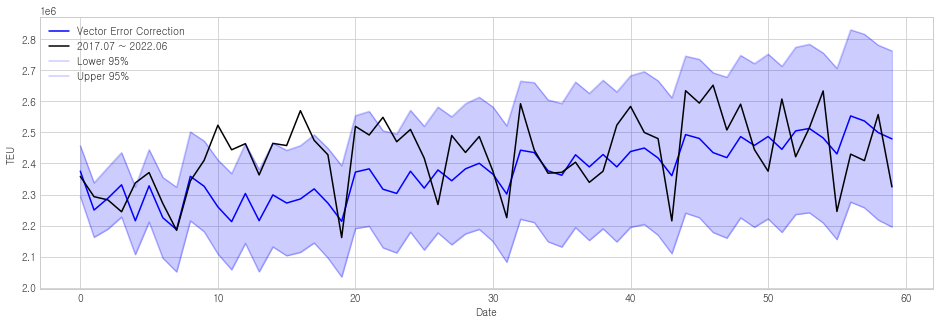

In [35]:
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(pd.DataFrame(forecast.round(2))[0], label='Vector Error Correction',color='blue')
plt.plot(df2['TEU'], label='2017.07 ~ 2022.06',color='black')
plt.plot(pd.DataFrame(lower.round(2))[0], label='Lower 95%',color='blue',alpha=0.2)
plt.plot(pd.DataFrame(upper.round(2))[0], label='Upper 95%',color='blue',alpha=0.2)
plt.fill_between(df2['TEU'].index, pd.DataFrame(lower.round(2))[0], pd.DataFrame(upper.round(2))[0], alpha=0.2,color='blue')
plt.legend(loc=2)

mse = mean_squared_error(df2['TEU'], pd.DataFrame(forecast.round(2))[0])
#print('MSE: '+str(mse))
rmse = math.sqrt(mse)
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((df2['TEU']-pd.DataFrame(forecast.round(2))[0])/df2['TEU'])*100) )